# SHapley Additive exPlanations applied to Retail Genius use case

In this notebook, we will use the SHAP library to apply the game theory to machine learning and have a better understanding of our model and its performances.

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../py_files')
from py_files.train import build_model
from py_files.preprocess import preprocess
import shap
np.random.seed(101)
shap.initjs()

In [2]:
training_data_df = pd.read_csv('../data/Dataset/ECommerce.csv')
training_data_df.head(5)


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


Our dataset is successfully loaded, we will now apply the preprocessing function we designed and used in the Ecommerce-final notebook:

In [3]:
# Preprocess the training data
data = preprocess(training_data_df)
data.head(5)

,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,...,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3,2,9,1,11.0,1.0,1.0,5.0,160,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4,3,7,1,15.0,0.0,1.0,0.0,121,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4,3,6,1,14.0,0.0,1.0,3.0,120,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4,5,8,0,23.0,0.0,1.0,3.0,134,1
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,5,3,0,11.0,1.0,1.0,3.0,130,1


We can now move to the model training and prediction phase. As the SHAP library is designed to handle inputs from sklearn, we will reuse the code from our train.py file but execute it line by line instead of using the build_model function. 

In [4]:
''' function for reference:

def build_model(data: pd.DataFrame) -> dict:

    X = data.drop(columns='Churn')
    y = data['Churn']
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=30)

    log_reg = LogisticRegression(solver='lbfgs',  max_iter=1000)
    log_reg.fit(X_train, y_train)
    
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    model_performance = {'accuracy': accuracy, 'classification_report': report}
    return model_performance
'''

" function for reference:\n\ndef build_model(data: pd.DataFrame) -> dict:\n\n    X = data.drop(columns='Churn')\n    y = data['Churn']\n    \n    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=30)\n\n    log_reg = LogisticRegression(solver='lbfgs',  max_iter=1000)\n    log_reg.fit(X_train, y_train)\n    \n    y_pred = log_reg.predict(X_test)\n    accuracy = accuracy_score(y_test, y_pred)\n    report = classification_report(y_test, y_pred, output_dict=True)\n    \n    model_performance = {'accuracy': accuracy, 'classification_report': report}\n    return model_performance\n"

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

X = data.drop(columns='Churn')
y = data['Churn']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=30)

In [6]:
log_reg = LogisticRegression(solver='lbfgs',  max_iter=5000)
log_reg.fit(X_train, y_train)
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1379
           1       0.75      0.55      0.63       310

    accuracy                           0.88      1689
   macro avg       0.83      0.75      0.78      1689
weighted avg       0.88      0.88      0.88      1689



Now that our model is ready, we can use the Explainer module from the SHAP library. This module will help us to understand the impact of each features on model performance.

In [7]:
explainer = shap.Explainer(
    log_reg, X_train, feature_names=X_train.columns
)
shap_values = explainer(X_test)

In [8]:
# printing columns in X_train for later use
i = 0
for columns in X_train.columns:
    print(f"This is column {i} : {columns}")
    print('')
    i+=1

This is column 0 : PreferredLoginDevice_Computer

This is column 1 : PreferredLoginDevice_Mobile Phone

This is column 2 : PreferredLoginDevice_Phone

This is column 3 : PreferredPaymentMode_CC

This is column 4 : PreferredPaymentMode_COD

This is column 5 : PreferredPaymentMode_Cash on Delivery

This is column 6 : PreferredPaymentMode_Credit Card

This is column 7 : PreferredPaymentMode_Debit Card

This is column 8 : PreferredPaymentMode_E wallet

This is column 9 : PreferredPaymentMode_UPI

This is column 10 : Gender_Female

This is column 11 : Gender_Male

This is column 12 : PreferedOrderCat_Fashion

This is column 13 : PreferedOrderCat_Grocery

This is column 14 : PreferedOrderCat_Laptop & Accessory

This is column 15 : PreferedOrderCat_Mobile

This is column 16 : PreferedOrderCat_Mobile Phone

This is column 17 : PreferedOrderCat_Others

This is column 18 : MaritalStatus_Divorced

This is column 19 : MaritalStatus_Married

This is column 20 : MaritalStatus_Single

This is column 

In [10]:
churner_index = []
non_churner_index = []

for i, value in enumerate(y_test):
    if value == 1:
        churner_index.append(i)
    else:
        non_churner_index.append(i)

print(churner_index)
print(non_churner_index)

[0, 4, 7, 12, 15, 16, 19, 35, 48, 49, 51, 58, 62, 64, 69, 75, 84, 87, 92, 96, 97, 113, 118, 119, 120, 123, 124, 128, 131, 132, 133, 139, 142, 153, 154, 156, 159, 164, 170, 175, 178, 182, 184, 186, 193, 196, 197, 211, 214, 218, 220, 228, 242, 243, 244, 248, 250, 260, 263, 270, 272, 282, 286, 298, 305, 307, 308, 315, 321, 329, 333, 334, 336, 340, 344, 348, 352, 353, 354, 357, 358, 370, 378, 383, 396, 406, 412, 420, 422, 429, 439, 444, 445, 449, 451, 468, 472, 476, 481, 492, 497, 501, 510, 512, 520, 527, 531, 535, 538, 540, 546, 547, 548, 561, 563, 564, 567, 574, 579, 586, 590, 597, 606, 607, 615, 622, 630, 632, 633, 634, 640, 643, 652, 660, 672, 676, 688, 692, 694, 701, 707, 714, 720, 726, 728, 748, 752, 753, 754, 759, 769, 788, 800, 801, 805, 810, 814, 819, 829, 830, 843, 845, 848, 853, 859, 862, 872, 873, 885, 897, 899, 901, 904, 911, 912, 920, 936, 937, 940, 942, 946, 947, 950, 953, 954, 959, 969, 983, 990, 991, 993, 1011, 1021, 1025, 1028, 1036, 1039, 1041, 1044, 1049, 1053, 1054, 10

We are trying to predict if a customer is a churner or not. High SHAP values means the customer is more likely to not be a churner.
So in our plots below, the red features are increasing the probability of a churn, while blue ones reduce it:

In [11]:
print("Not Churner")
shap.plots.force(shap_values[1])

Not Churner


In [15]:
print("Churner")
shap.plots.force(shap_values[0])

Churner


As we can see, if we compare a churner with a non churner, the graph are somehow alike and still very different. 

First, some features are present in both case but switch place: the "Tenure" one is the most obvious and seems to indicate that a customer with a short tenure is more likely to churn.

On the other side, it is interesting to see which features are present for a churner when they are **not** present for a "loyal" customer. For example, "cashback amount" and "satisfaction score" have bigger weights in the case of a churner. Same logic applies with the "day since last order" variable: its weights is more obvious for a "loyal" customer than for a churner. 

Let's try to plot a couple of churners in a row to see what we can observe.

In [23]:
i = np.random.choice(churner_index)
print(i)
shap.plots.force(shap_values[i])

19


In [24]:
i = np.random.choice(churner_index)
print(i)
shap.plots.force(shap_values[i])

954


In [25]:
i = np.random.choice(churner_index)
print(i)
shap.plots.force(shap_values[i])

1631


At first sight we observe that "Tenure", "Complain", "Day since last order", "Number of address" and "Cashback amount", seems to play a strong role in the chance of churning or not. 

To have a better overview of this, we can use the "beeswarm" graph from SHAP. In the documentation, the graph is defined as "designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value".

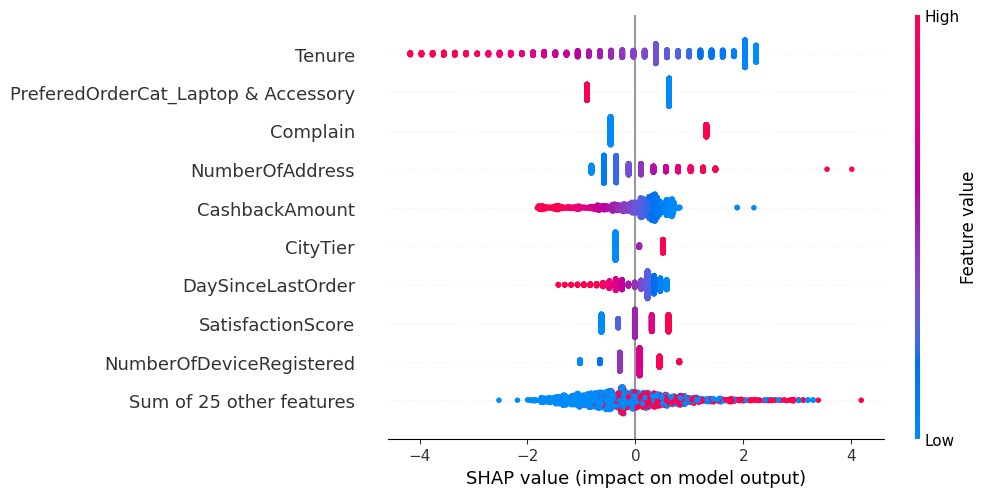

In [26]:
# plotting shap values
shap.plots.beeswarm(shap_values)